In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration

In [3]:
weekly_price_data = pd.read_csv("Finalized_Weekly_Prices.csv")
weekly_price_data.head()

,Year,Week_Nr,Open,High,Low,Volume,Close/Last
0,2019,18,373.68,385.99,368.348,27414636,385.03
1,2019,19,377.69,381.35,352.750,30879720,361.04
2,2019,20,352.29,364.00,341.390,30886755,354.45
3,2019,21,351.23,370.46,345.400,24338679,354.39
4,2019,22,354.39,361.20,342.920,19407548,343.28


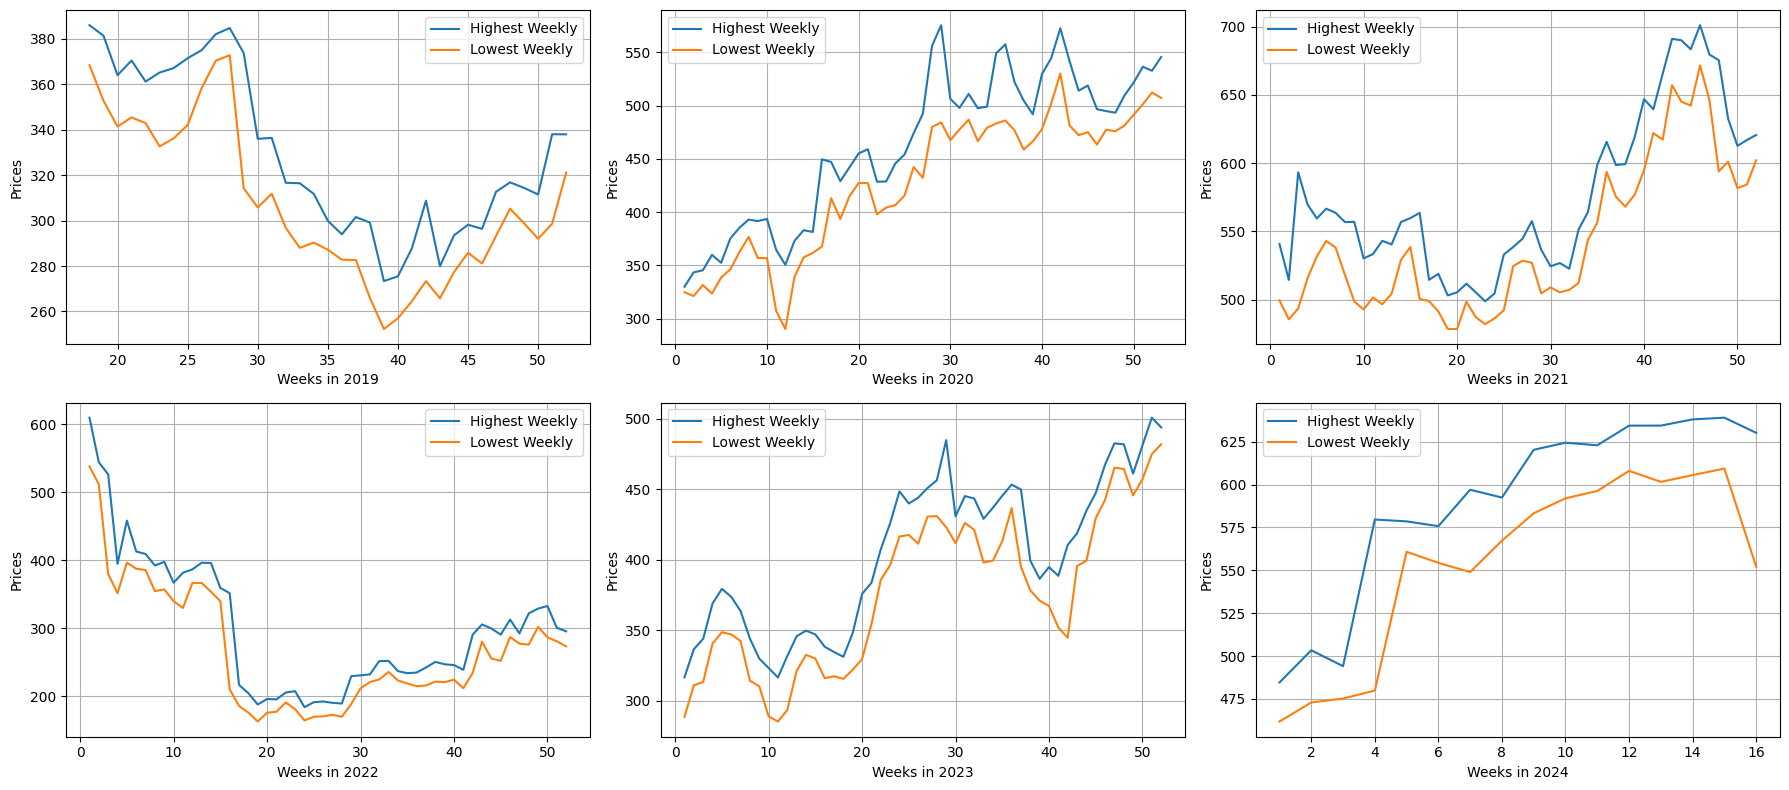

In [4]:
# "axes" has a special 'Axes' data type 

# Creates 2x3 grid of subplots
# The 'figsize' is in inches (18 wide and 8 high)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# "axes" is a 2D array of Axes, so we flatten it to create a 1D array which is
# easier to work with
ax_flat = axes.flatten() 

i = 0 # used for iterating through the subplots

for year in weekly_price_data["Year"].unique():
    plot_df = weekly_price_data.loc[weekly_price_data["Year"] == year,
                                    ["Week_Nr", "High", "Low"]]
    x_axis = plot_df["Week_Nr"]
    highest_WP = plot_df["High"] # hiehest week prices
    lowest_WP = plot_df["Low"] # lowest week prices

    axes = ax_flat[i]

    axes.plot(x_axis, highest_WP, label = "Highest Weekly")
    axes.plot(x_axis, lowest_WP, label = "Lowest Weekly")
    
    axes.set_xlabel("Weeks in "+str(year))
    axes.set_ylabel("Prices")
    axes.legend()
    axes.grid()

    i += 1

plt.tight_layout()
plt.show()

Based in the graphs, everything seems as expected. Nothing too abnormal.

## Model Training

In [5]:
X_data = weekly_price_data.iloc[:, :-1]
y_data = weekly_price_data.iloc[:, -1]
X_data

,Year,Week_Nr,Open,High,Low,Volume
0,2019,18,373.68,385.9900,368.3480,27414636
1,2019,19,377.69,381.3500,352.7500,30879720
2,2019,20,352.29,364.0000,341.3900,30886755
3,2019,21,351.23,370.4600,345.4000,24338679
4,2019,22,354.39,361.2000,342.9200,19407548
...,...,...,...,...,...,...
255,2024,12,613.56,634.3617,608.0000,12769725
256,2024,13,627.90,634.3899,601.5900,10944787
257,2024,14,608.00,638.0000,605.5101,13519564
258,2024,15,636.39,639.0000,609.3400,12720545


### Algorithm Selection and Dataset Split Reasoning

Since this is a **small** dataset, I can rule out very complex algorithms such as *Neural Networks*.

Since this is a **regression** problem, I can rule out any algorithm that only works with **classification**.\
For Example: Logistic Regression.

Since this is no obvious *linear relationships* between the different features (across the years), I'm going to rule out **Linear Regression**\
aswell. I'll chose **K-Nearest Neighbors** since it works well with *small datasets* and is better suited for *non-linear relationships*\
compared to **Linear Regression**.

Since the dataset is quite small, too small for a 3-way split, I'm going to use a **2-way** split with **cross-validation** instead.

### Algorithm Selection and Dataset Split Code

In [6]:
# I'll be using the Walk-Forward Validation techique (a type of time-series cross-validation technique)
# to simulate stock trading senarios.  

from sklearn.neighbors import KNeighborsRegressor  

walk_forward_step = 1 # number of weeks in validation set

# 'training_window' is the number of weeks in the training set
def train_model(training_window, num_neighbors):
    predictions = []

    for i in range(training_window, len(X_data.index), walk_forward_step):
        # data in that training window
        X_train = X_data.iloc[(i - training_window):i]
        y_train = y_data.iloc[(i - training_window):i]

        knn = KNeighborsRegressor(n_neighbors=num_neighbors)
        knn.fit(X_train, y_train)
        
        X_valid = X_data.iloc[i] # Series
        X_valid = pd.DataFrame([X_valid]) # Converted to DataFrame

        # Make and store predictions
        predicted_price = knn.predict(X_valid)
        predictions.append(predicted_price[0])
    
    return predictions

prediction_list = train_model(4, 4)

print("Success")

Success


### Results Before Fine-Tuning

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def display_metrics(y_true, y_predicted):
    mae = mean_absolute_error(y_true, y_predicted)
    mae_perc = mean_absolute_percentage_error(y_true, y_predicted)
    
    print("Mean Absolute Error (MAE): ", "{:.2f}".format(mae), sep="\t")
    print("Mean Absolute Percentage Error (MAPE): ", "{:.2f}%".format(mae_perc), sep="\t\t")

display_metrics(y_data.iloc[4:], prediction_list)

Mean Absolute Error (MAE): 	23.65
Mean Absolute Percentage Error (MAPE): 		0.06%


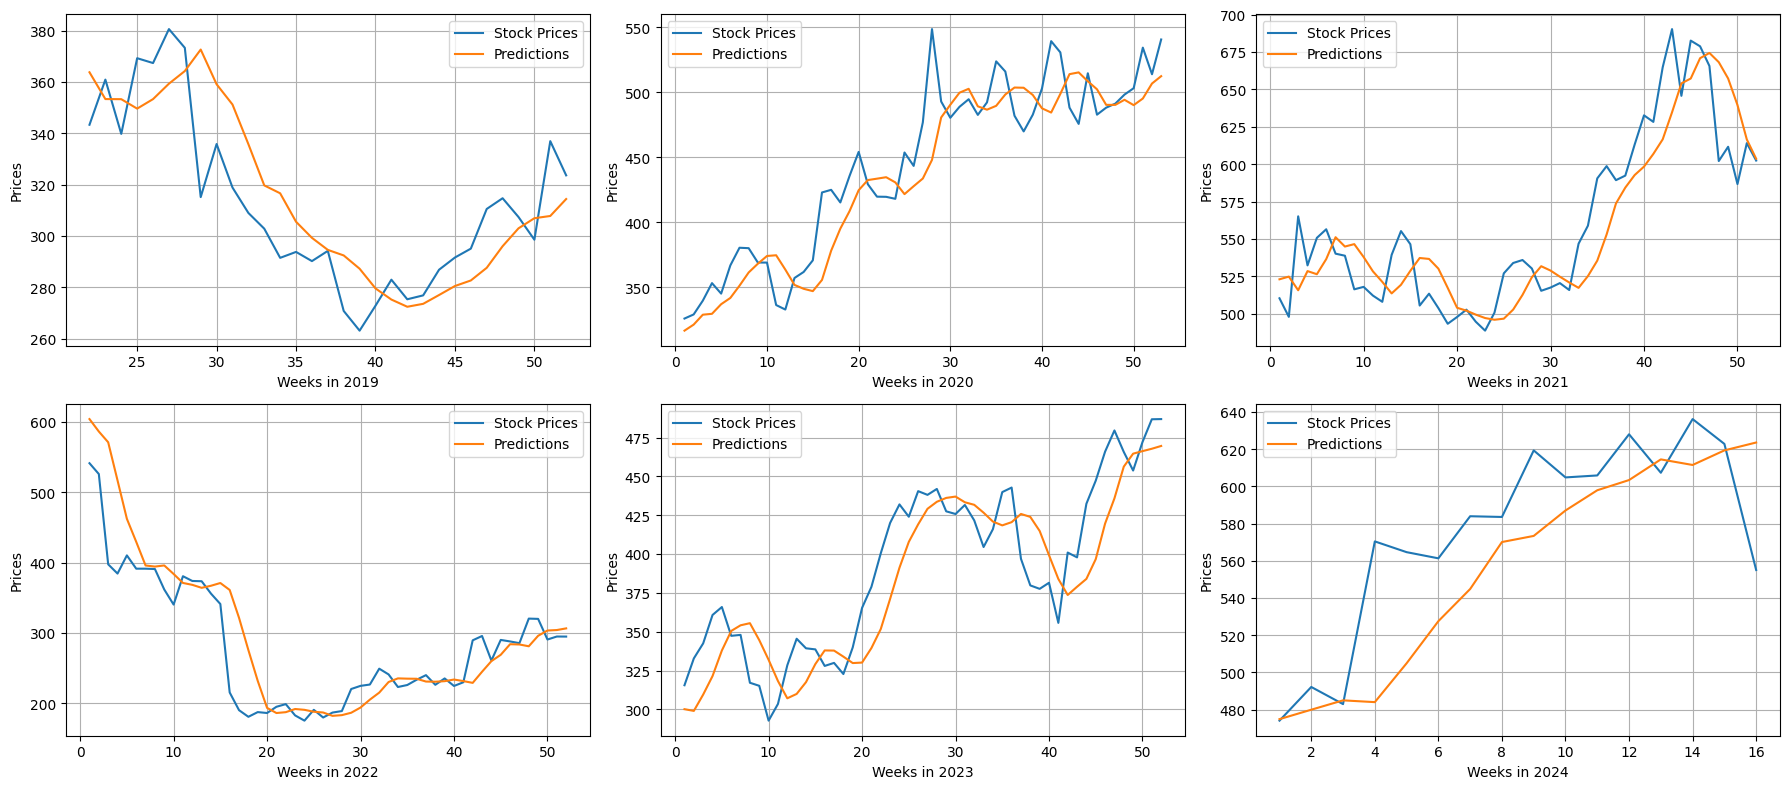

In [8]:

def predictionsCompared(prediction_list: list, training_window_num: int):
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    ax_flat = axes.flatten() 
    i = 0

    plot_df = weekly_price_data.loc[training_window_num:] 

    prediction_df = pd.DataFrame({"Year": plot_df["Year"]})
    prediction_df.insert(1, "Predictions", prediction_list)

    for year in plot_df["Year"].unique():
        yearly_plot_df = plot_df.loc[plot_df["Year"] == year, ["Week_Nr", "Close/Last"]]
        x_axis = yearly_plot_df["Week_Nr"]

        actual_prices = yearly_plot_df["Close/Last"]
        predictions = prediction_df.loc[prediction_df["Year"] == year, "Predictions"]

        axes = ax_flat[i]

        axes.plot(x_axis, actual_prices, label = "Stock Prices")
        axes.plot(x_axis, predictions, label = "Predictions")
        
        axes.set_xlabel("Weeks in "+str(year))
        axes.set_ylabel("Prices")
        axes.legend()
        axes.grid()

        i += 1

    plt.tight_layout()
    plt.show()

predictionsCompared(prediction_list, 4)

### Fine-Tuning

In [9]:
trainWindSizes = [4, 8, 12, 16, 20, 24] # Training Window sizes

predResult_lists = [] # a list of a list of prediction results

predResult_lists.append(train_model(trainWindSizes[0], 4))
predResult_lists.append(train_model(trainWindSizes[1], 4))
predResult_lists.append(train_model(trainWindSizes[2], 4))
predResult_lists.append(train_model(trainWindSizes[3], 4))
predResult_lists.append(train_model(trainWindSizes[4], 4))
predResult_lists.append(train_model(trainWindSizes[5], 4))

In [10]:
mae_list = []
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[0]:], predResult_lists[0]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[1]:], predResult_lists[1]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[2]:], predResult_lists[2]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[3]:], predResult_lists[3]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[4]:], predResult_lists[4]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[5]:], predResult_lists[5]))

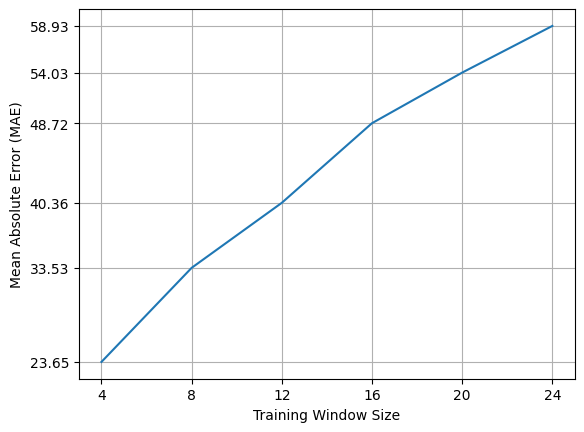

In [11]:
plt.plot(trainWindSizes, mae_list)
plt.xlabel("Training Window Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(trainWindSizes) # To control the exact x-axis values that's being shown
plt.yticks(mae_list)
plt.grid()
plt.show()

In [12]:
trainWindSizes.insert(0, 1)
trainWindSizes.insert(1, 2)

# Becuase of the smaller training window, logically, the number of neighbors has to decrease 
predResult_lists.insert(0, train_model(trainWindSizes[0], 1)) 
predResult_lists.insert(1, train_model(trainWindSizes[1], 2))

mae_list.insert(0, mean_absolute_error(y_data.iloc[trainWindSizes[0]:], predResult_lists[0]))
mae_list.insert(1, mean_absolute_error(y_data.iloc[trainWindSizes[1]:], predResult_lists[1]))

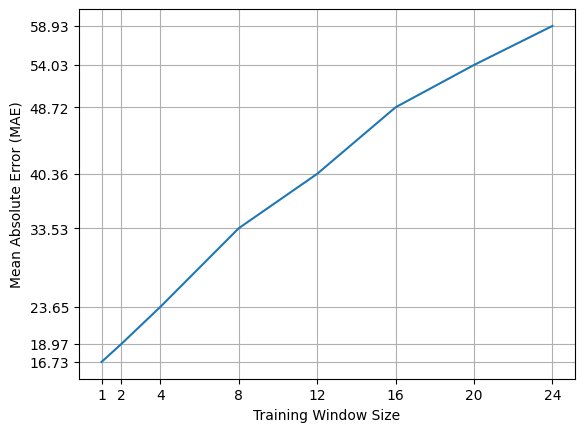

In [13]:
plt.plot(trainWindSizes, mae_list)
plt.xlabel("Training Window Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(trainWindSizes)
plt.yticks(mae_list)
plt.grid()
plt.show()

Side Note: Result from Training Window Size 4 and above, the K value of KNN stays consistent (4 neighbors)  

In [14]:
print("Metrics of Training Window Size 1:\n")

mape = mean_absolute_percentage_error(y_data.loc[1:], predResult_lists[0])

print("Mean Absolute Error (MAE):", "{:.2f}".format(mae_list[0]), sep="\t")
print("Mean Absolute Percentage Error (MAPE):", "{:.2f}%".format(mape), sep="\t")

Metrics of Training Window Size 1:

Mean Absolute Error (MAE):	16.73
Mean Absolute Percentage Error (MAPE):	0.04%


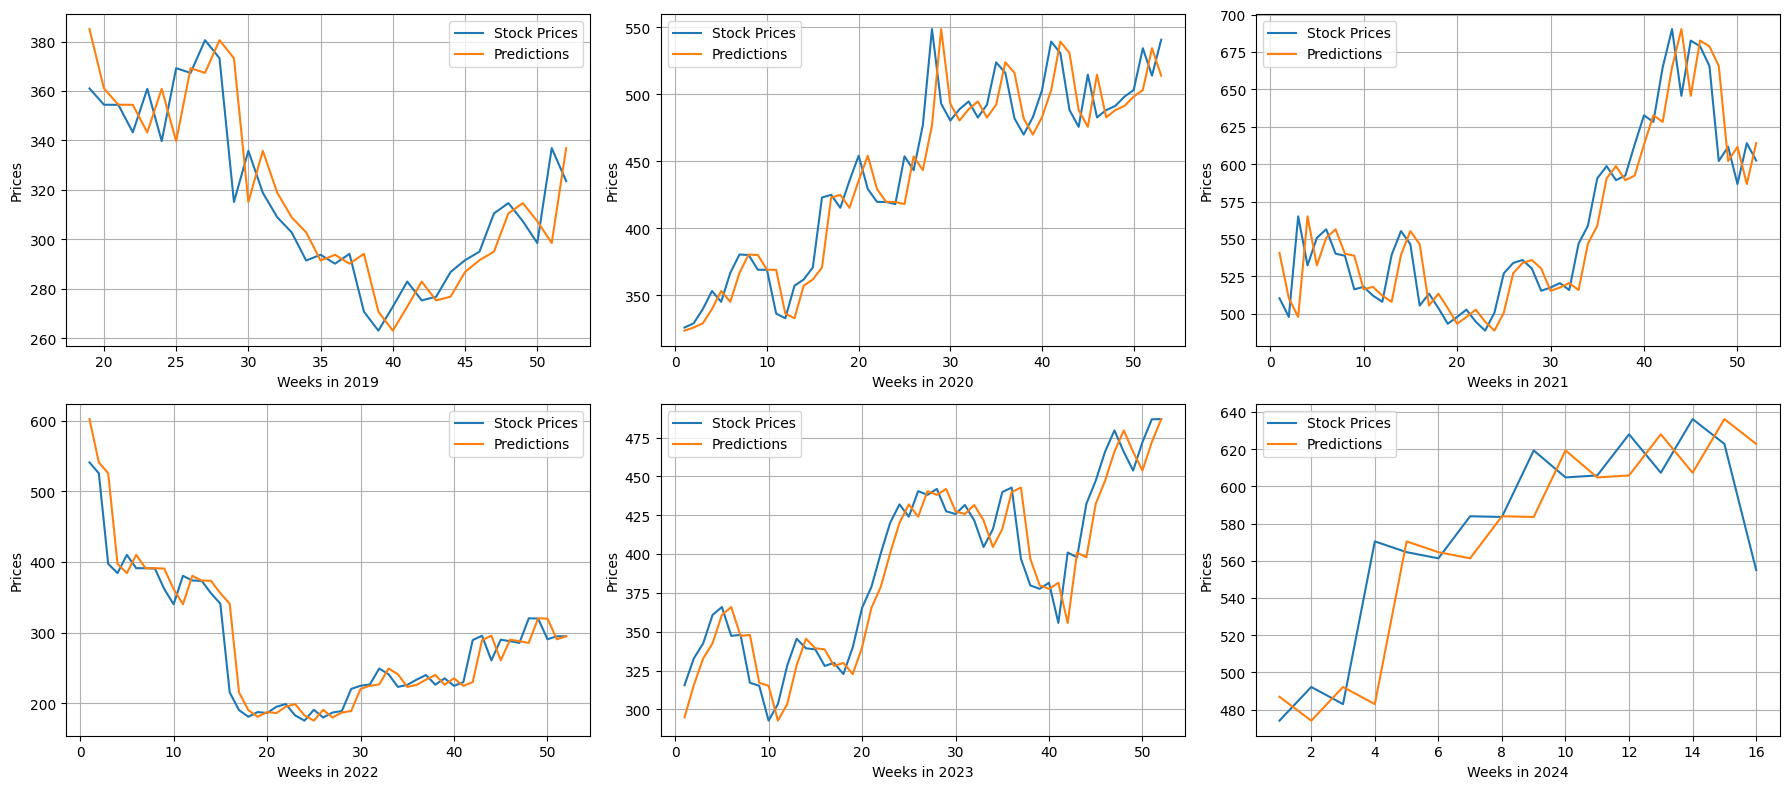

In [15]:
predictionsCompared(predResult_lists[0], trainWindSizes[0])

In [17]:
predResult = train_model(16, 16)
display_metrics(y_data[16:], predResult)


Mean Absolute Error (MAE): 	49.84
Mean Absolute Percentage Error (MAPE): 		0.14%


In [19]:
trainWindSizes

[1, 2, 4, 8, 12, 16, 20, 24]

In [25]:
# Adjusting lists for the next graph (for evaluation)
for _ in range(5):
    predResult_lists.pop()
    mae_list.pop()
print("Removed last 5 elements from 'predResult_lists' and 'mae_list'")    


Removed last 5 elements from 'predResult_lists' and 'mae_list'


In [28]:
predResult_lists.append(train_model(trainWindSizes[3], 8))
predResult_lists.append(train_model(trainWindSizes[4], 12))
predResult_lists.append(train_model(trainWindSizes[5], 16))
predResult_lists.append(train_model(trainWindSizes[6], 20))
predResult_lists.append(train_model(trainWindSizes[7], 24))

In [29]:
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[3]:], predResult_lists[3]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[4]:], predResult_lists[4]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[5]:], predResult_lists[5]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[6]:], predResult_lists[6]))
mae_list.append(mean_absolute_error(y_data.iloc[trainWindSizes[7]:], predResult_lists[7]))

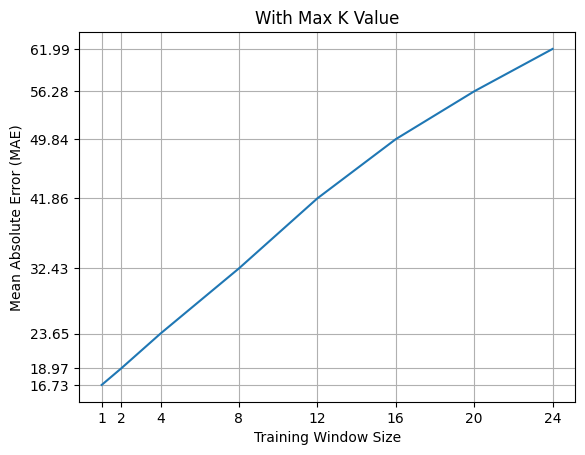

In [30]:
plt.plot(trainWindSizes, mae_list)
plt.xlabel("Training Window Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(trainWindSizes)
plt.yticks(mae_list)
plt.title("With Max K Value") # Where we always have the highest value of K per Training Window Size
plt.grid()
plt.show()

No Improvement. So I'll assume a Training Window Size of 1 is the most optimal.